# HW1 Regression
**COVID-19 Cases Prediction**

Objectives:
* Solve a regression problem with deep neural networks (DNN). 使用深度神经网络（DNN）解决回归问题。
* Understand basic DNN training tips. 理解深度神经网络的基本训练技巧。
* Get familiar with PyTorch. 熟悉 PyTorch。

Datasets: https://www.kaggle.com/c/ml2021spring-hw1

In [3]:
# HomeworkID
HOMEWORK_ID = "hw1"
# Res Directory
RES_DIR = f"res/{HOMEWORK_ID}/"
# Output Directory
OUTPUT_DIR = f"output/{HOMEWORK_ID}/"
# Random Seed
RANDOM_SEED = 42

In [ ]:
# Import packages

# For data preprocess
import numpy as np
import pandas as pd
import os
import csv
import random

# Pytorch and Keras
import torch
from torch.utils.data import DataLoader, Dataset
import keras
from keras import layers, ops, regularizers

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [5]:
# Some Utilities
def get_device():
    ''' Returns the available device: GPU if available, else CPU '''
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_random_seed(seed_value=RANDOM_SEED):
    ''' Sets the random seed for reproducibility '''
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True # 强制CuDNN使用确定性算法
        torch.backends.cudnn.benchmark = False # 关闭CuDNN的自动优化功能

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train']) # 训练总步数
    x_1 = range(total_steps)  # 训练集的x轴坐标
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])] # 验证集的x轴坐标（因为验证通常比训练频率低，会从训练点中每隔100个取一个点，与验证点对齐）
    figure(figsize=(6, 4)) # 设置图形大小
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train') # 画出训练集损失曲线
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev') # 画出验证集损失曲线
    plt.ylim(0.0, 5.) # y轴限制在0-5之间
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend() # 显示图例
    plt.show()

In [6]:
# GPU Checking
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{'='*40}")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"Current Backend: {keras.backend.backend()}")
print(f"{'='*40}")

# Set random seed for reproducibility
set_random_seed(RANDOM_SEED)
print(f"Random seed set to: {RANDOM_SEED}")
print(f"{'='*40}")

# Make sure directory exists
os.makedirs(RES_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

Using device: cuda
PyTorch version: 2.9.1+cu130
Keras Version: 3.13.0
Current Backend: torch
Random seed set to: 42


## Dataset and Model

In [8]:
# path to training data
TRAIN_CSV = os.path.join(RES_DIR, 'covid.train.csv')
# path to test data
TEST_CSV = os.path.join(RES_DIR, 'covid.test.csv')

In [9]:
# Dataset
class COVID19Dataset:
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                path,
                mode='train',
                target_only=False):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float) # Skip header & ID column
        
        if not target_only:
            feats = list(range(93)) # 使用所有93个特征
        else:
            feats = list(range(40)) + [57, 75] # 使用40个州的特征和2个tested_positive特征 (indices = 57 & 75)

        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = data.astype(np.float32)
            self.target = None
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]
            
            # Splitting training data into train & dev sets (9:1 split)
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]
            
            # Convert data into numpy arrays
            self.data = data[indices].astype(np.float32)
            self.target = target[indices].astype(np.float32)

        # Normalize features (you may remove this part to see what will happen)
        mean = np.mean(self.data[:, 40:], axis=0, keepdims=True)
        std = np.std(self.data[:, 40:], axis=0, keepdims=True)
        self.data[:, 40:] = (self.data[:, 40:] - mean) / std

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
            .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index] if self.target is not None else None
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

In [10]:
# DataLoader
class PyTorchDatasetWrapper(Dataset):
    ''' A wrapper to make COVID19Dataset compatible with PyTorch DataLoader '''
    def __init__(self, covid19_dataset):
        self.dataset = covid19_dataset

    def __getitem__(self, index):
        return self.dataset[index]
    
    def __len__(self):
        return len(self.dataset)

def get_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only) # Generates a dataset
    torch_dataset = PyTorchDatasetWrapper(dataset) # Wraps it for PyTorch
    dataloader = DataLoader(
        torch_dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True) # Construct dataloader

    return dataloader, dataset.dim

In [84]:
# Neural Network Model (使用 Keras 3.0 API，底层是 PyTorch)
def create_neural_net(input_dim, hidden_units=[64], dropout_rate=0.0):
    ''' A simple fully-connected deep neural network '''
    # input layer
    inputs = keras.Input(shape=(input_dim,))
    x = inputs
    # hidden layers
    for units in hidden_units:
        x = layers.Dense(units, activation='relu')(x)
        if dropout_rate > 0.0:
            x = layers.Dropout(dropout_rate)(x)
    # output layer
    outputs = layers.Dense(1)(x)  # Output layer for regression
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

In [86]:
# train
def train(model:keras.Model, train_loader:DataLoader, dev_loader:DataLoader, epochs=100, lr=1e-3):
    ''' Train the DNN model '''
    # Compile the model with optimizer and loss function
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                loss='mse')

    history = model.fit(
        train_loader,
        validation_data=dev_loader,
        epochs=epochs,
        verbose=1,
        callbacks=[
            keras.callbacks.EarlyStopping(
                patience=200, 
                restore_best_weights=True
            ),
        ],
    )

    return model, history

## Training

In [ ]:
# Hyperparameters
hidden_units = [128, 64]
learning_rate = 1e-3
epochs = 1000
batch_size = 270
target_only = False
dropout_rate = 0.0

In [99]:
# Load data and model
train_loader, input_dim = get_dataloader(TRAIN_CSV, mode='train', batch_size=batch_size, target_only=target_only)
dev_loader, _ = get_dataloader(TRAIN_CSV, mode='dev', batch_size=batch_size, target_only=target_only)
test_loader, _ = get_dataloader(TEST_CSV, mode='test', batch_size=batch_size, target_only=target_only)

model = create_neural_net(input_dim,
                        hidden_units=hidden_units,
                        dropout_rate=dropout_rate)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss='mse')

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 93)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 93)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 93)


Epoch 1/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 290.3127 - val_loss: 251.7218
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 221.1031 - val_loss: 176.9378
Epoch 3/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 141.3393 - val_loss: 94.0506
Epoch 4/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 65.4707 - val_loss: 39.8182
Epoch 5/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 35.2036 - val_loss: 36.2304
Epoch 6/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 31.5042 - val_loss: 26.9665
Epoch 7/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 23.5671 - val_loss: 22.2123
Epoch 8/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 21.4437 - val_loss: 20.1492
Epoch 9/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 19.0977 - val_loss: 17.9147
Epoch 10/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17.2295 - val_loss: 16.2030
Epoch 11/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 15.4056 - val_loss: 14.4579
Epoch 12/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/s

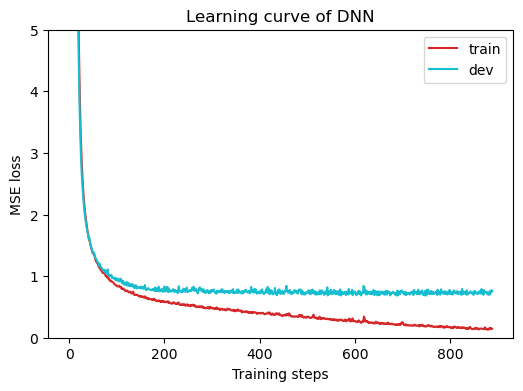

In [100]:
# Training
model, history = train(model, train_loader, dev_loader, epochs=epochs, lr=learning_rate)
# Saving the trained model
model.save(os.path.join(OUTPUT_DIR, f'model_lr{learning_rate}_bs{batch_size}_epochs{epochs}.keras'))
# Plot learning curve
loss_record = {
    'train': history.history['loss'],       # 训练集损失
    'dev': history.history['val_loss']      # 验证集损失
}
plot_learning_curve(loss_record, title='DNN')

In [101]:
# Prediction
predictions = model.predict(test_loader)
# Save predictions to CSV
output_path = os.path.join(OUTPUT_DIR, 'pred.csv')
with open(output_path, 'w', newline='') as fp:
    writer = csv.writer(fp)
    writer.writerow(['id', 'tested_positive'])
    for i, pred in enumerate(predictions):
        writer.writerow([i, pred[0]])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
